# Skill assessment - probabilistic
***

**Author**: Chus Casado Rodr√≠guez<br>
**Date**: 03-03-2023<br>


**Introduction**:<br>


**Questions**:<br>
* [x] Weighting the model average by the Brier score?
* [ ] Take into account the model spread?
* [x] Sort stations by catchment area (or other order)?
* [ ] Persistence
* [ ] Analyse only the periods/stations close to an observed event and compute f1 for this extraction. Later on, on the complementary subset of data another metric must be computed to avoid false positives, p.e., false alarm ratio.

**Tasks to do**:<br>
* What's `pred_event` for?

**Interesting links**<br>
[Evaluation metrics for imbalanced classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)<br>
[Cross entropy for machine learning](https://machinelearningmastery.com/cross-entropy-for-machine-learning/)<br>
[Probability metrics for imbalanced classification](https://machinelearningmastery.com/probability-metrics-for-imbalanced-classification/)<br>
[ROC curves and precision-recall curves for imbalanced classification](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cf
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix

path_root = os.getcwd()

import warnings
warnings.filterwarnings("ignore")

os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

os.chdir('../py/')
from efas_skill import *
os.chdir(path_root)

## 1 Data

In [2]:
name = 'EFAS'

# path where results will be saved
results_path = '../results/'
path_out = f'{results_path}skill/{name}/eventwise/'
if os.path.exists(path_out) is False:
    os.makedirs(path_out)

In [3]:
# coordinate reference system when plotting maps
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=10, central_latitude=52, false_easting=4321000, false_northing=3210000, globe=ccrs.Globe(ellipse='GRS80'))

### 1.1 Stations

I load all the stations that where selected in a previous [notebook](3_0_select_stations.ipynb).

In [4]:
# load selected points for all the catchments
stations = pd.DataFrame()
catchments = []
folders = os.listdir(f'{results_path}reporting_points/')
for folder in folders:
    try:
        stn_cat = pd.read_csv(f'{results_path}reporting_points/{folder}/points_selected.csv', index_col='station_id')
        stations = pd.concat((stations, stn_cat))
        catchments.append(folder)
    except:
        continue
print('no. stations:\t\t\t{0}'.format(stations.shape[0]))

no. stations:			900


In [5]:
# # shapefile with rivers
# rivers_shp = gpd.read_file(f'../data/GIS/RiversForWebPage_EU_ready.shp')
# mask = rivers_shp.BASIN.isin(catchments)
# rivers_shp = rivers_shp.loc[mask]

### 1.2 Forecast: exceedance

I load the preprocessed forecast data. In a previous [notebook](4_0_forecast_exceedance_review.ipynb), the forecasted discharge was converted to probability of exceeding the 5-year return period threshold. The ouput of that process is a NetCDF file per station with the forecasted probability of exceedance. 

In [6]:
# models
models = {'COS': {'members': 20, 'leadtimes': 22},
          'DWD': {'members': 1, 'leadtimes': 28},
          'EUD': {'members': 1, 'leadtimes': 40},
          'EUE': {'members': 51, 'leadtimes': 40},}
min_leadtime = min([models[m]['leadtimes'] for m in models])

In [7]:
# load probability of exceeding the discharge threshold in the FORECAST data
path_forecast = '../data/exceedance/forecast/'
fore_exc = {}
for stn in stations.index:
    da = xr.open_dataarray(f'{path_forecast}{stn:04d}.nc')
    if 'id' in da.coords:
        da = da.drop_vars('id')
    fore_exc[stn] = da
    da.close()

# convert into a Dataset
stn = stations.index[0]
fore_exc = xr.Dataset(fore_exc, coords={'model': fore_exc[stn].model,
                                        'forecast': fore_exc[stn].forecast,
                                        'leadtime': fore_exc[stn].leadtime})

In [8]:
# study period based on the extent of the forecast data
start, end = [(fore_exc.forecast[i] + fore_exc.leadtime[i]).data for i in [0, -1]]
start, end = [(date - np.datetime64('1970-01-01T01:00:00Z')) / np.timedelta64(1, 's') for date in [start, end]]
start, end = [datetime.fromtimestamp(timestamp) for timestamp in [start, end]]

print(f'Study period\nstart:\t{start}\nend:\t{end}')

Study period
start:	2021-01-01 06:00:00
end:	2023-01-10 12:00:00


In [9]:
# DataArray with weights for each model and leadtime
weights = np.zeros((len(fore_exc.model), len(fore_exc.leadtime)))
for i, (key, value) in enumerate(models.items()):
    leadtimes = value['leadtimes']
    members = value['members']
    weights[i,:leadtimes] = members
weights = xr.DataArray(weights, coords={'model': list(models), 'leadtime': fore_exc.leadtime})

### 1.3 Reanalysis: exceedance & events

I load the preprocessed reanalysis data. In a previous [notebook](2_2_reanalysis_preprocessing.ipynb), the reanalysis discharge data was preprocessed to create timeseries of exceedance over the 5-year return period threshold.

Out of the exceedance timeseries I calculate another timeseries of the onset of flood events.

In [10]:
path_reanalysis = '../data/exceedance/reanalysis/'

# load probability of exceeding the discharge threshold in the REANALYSIS data
rean_exc = pd.read_parquet(f'{path_reanalysis}/exceedance_rl5.parquet')
rean_exc.columns = rean_exc.columns.astype(int)
#start, end = datetime(2021, 1, 1, 6), datetime(2022, 1, 1, 6) + timedelta(hours=39*6)
# start, end = datetime(2021, 1, 1, 6), datetime(2022, 12, 31)
rean_exc = rean_exc.loc[start:end, stations.index.tolist()]

# compute onsets of the flood events
rean_onsets = rean_exc.astype(int).diff(axis=0) == 1
rean_onsets.iloc[0,:] = rean_exc.iloc[0,:]

# create a DataArray with the number of observed events per station
n_events_obs = xr.DataArray(rean_onsets.sum(), dims=['id'], coords={'id': rean_onsets.columns.tolist()})
print('no. events:\t\t\t{0}'.format(n_events_obs.sum().data))

# select stations with events
mask_stn = (n_events_obs > 0).to_pandas()
print('no. stations with events:\t{0}'.format(mask_stn.sum()))
# stations = stations.loc[mask_stn,:]
# rean_exc = rean_exc.loc[:,mask_stn]
# rean_onsets = rean_onsets.loc[:,mask_stn]
# print('no. stations with events:\t{0}'.format(stations.shape[0]))

no. events:			543
no. stations with events:	328


The number of events has increased after giving priority to reporting points upstream during the selection process.

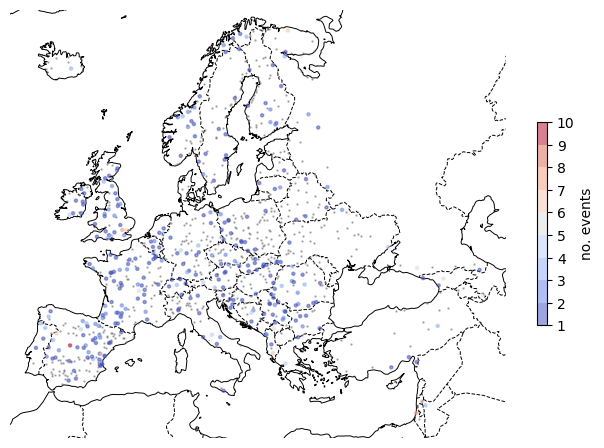

In [11]:
# colormap used for the maps
cmap = plt.cm.coolwarm
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('no. events', cmaplist, cmap.N)
bounds = np.arange(1, rean_onsets.sum().max(), 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plot_map_stations(stations.X, stations.Y, rean_onsets.sum(), mask=~mask_stn,
                  cmap=cmap, norm=norm, size=5, figsize=(8, 8))
plt.colorbar(plot_map_stations.colorbar, shrink=.33, label='no. events')
plt.savefig(f'{path_out}/map_observed_events.png', dpi=300, bbox_inches='tight');

## 2 Compute events

In this section I will create two boolean _DataArray_ with the onset of flood events, i.e., a matrix of zeros and ones where a one means the beginning of a flood.

* `obs_onsets` is a _DataArray_ with three dimensions that contains the "observed" events: 
    * `id`: the stations ID
    * `forecast`: the timestamp of the beginning of the forecast
    * `leadtime`: the timedelta of the specific timestep. The addition of forecast and leadtime renders the actual date and time of the timestep
* `pred_events` is a _DataArray_ with five dimensions that contains the forecasted events:
    * `id`
    * `forecast`
    * `leadtime`
    * `model` corresponds to the different procedures to compute the occcurrence of events.
        * `current` is the current EFAS criteria, i.e., at least a deterministic model must predict the flood, and one of the probabilistic models must predict a probability of event higher than a probability threshold.
        * `model_mean` computes total probability giving the same weight to every model, i.e., 25% weight to each of the 4 meteorological forcings.
        * `member_weighted` computes total probability giving the same weight to each run, i.e., probabilistic models (with more than 1 run) have a higher weight.
    * `probability` are different thresholds to consider a flood event.

In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [13]:
# probability thresholds
thresholds = np.arange(0.05, .96, .05).round(2) #np.hstack((np.array((.01, .02)), np.arange(0.05, .96, .05), np.array((.98, .99)))).round(2) #
# thresholds = np.round(sigmoid(np.linspace(-10, 10, 50)), 5)
probabilities = xr.DataArray(thresholds, dims=['probability'], coords={'probability': thresholds})

In [14]:
# # OBSERVED EVENTS & ONSETS
# # ........................
    
# obs_onsets = {}
# obs_events = {}
# for i, stn in enumerate(stations.index): 
#     # find onsets
#     mask = rean_onsets[stn]
#     onsets = rean_onsets.index[mask].tolist()
#     obs_onsets[stn] = dataarray_events(onsets, fore_exc.forecast, fore_exc.leadtime)
    
#     # find events
#     mask = rean_exc[stn]
#     exc = rean_exc.index[mask].tolist()
#     # create DataArray of the occurrence of events
#     obs_events[stn] = dataarray_events(exc, fore_exc.forecast, fore_exc.leadtime)
    
# obs_onsets = xr.Dataset(obs_onsets).to_array(dim='id', name='events')
# obs_events = xr.Dataset(obs_events).to_array(dim='id', name='events')

```Python
stn = 119

fig, axes = plt.subplots(nrows=2, figsize=(16, 8), sharex=True, sharey=True)

for ax, da in zip(axes, [obs_events.sel(id=stn), obs_onsets.sel(id=stn)]):
    sns.heatmap(da.transpose(), ax=ax, cmap='Blues')
    ax.tick_params(length=0)
```

In [15]:
# # PREDICTED EVENTS & ONSETS
# # .........................

# # CURRENT CRITERIA

# # compute events for each probability threshold

# # compute exceendace of probability thresholds
# current = fore_exc.to_array(dim='id', name='current')
# exceedance0 = current > probabilities
# # find where the deterministic criteria was fulfilled
# deterministic = exceedance0.sel(model=['DWD', 'EUD']).sum('model')
# # find where the probabilistic criteria was fulfilled
# probabilistic = exceedance0.sel(model=['COS', 'EUE']).sum('model')
# # find where both the deterministic and the probabilistic criteria was fulfilled
# events0 = ((deterministic >= 1) & (probabilistic >= 1))

# # compute the onset of events for each probability threshold

# steps0 = events0.astype(int).diff('leadtime') == 1
# step0_0 = events0.isel(leadtime=0)
# onsets0 = xr.concat((step0_0, steps0), 'leadtime')

# # NEW CRITERIA

# # compute events for each probability threshold and two new criteria: model mean, weighted mean
# model_mean = fore_exc.mean('model').to_array(dim='id', name='model_mean')
# member_weighted = fore_exc.weighted(weights).mean('model').to_array(dim='id', name='member_weighted')
# exceedance12 = xr.merge([model_mean, member_weighted])
# events12 = exceedance12 > probabilities

# # compute the onset of events for each probability threshold
# steps12 = events12.astype(int).diff('leadtime') == 1
# step12_0 = events12.isel(leadtime=0)
# onsets12 = xr.concat((step12_0, steps12), 'leadtime')

# # join the three criteria
# pred_events = xr.merge([events0.to_dataset(name='current'), events12]).to_array(dim='model', name='events')
# pred_onsets = xr.merge([onsets0.to_dataset(name='current'), onsets12]).to_array(dim='model', name='onsets')

## 3 Assess skill

In this section I will compute the skill of the EFAS predictions in different ways. In all the following sections I will work with three metrics: recall, precision and the f1-score. The three metrics are based in the contingency table of hits ($TP$ for true positives), false alarms ($FP$ for false positives) and misses ($FN$ for false negatives).

$$recall = \frac{TP}{TP + FN}$$
$$precision = \frac{TP}{TP + FP}$$
$$f1 = \frac{2 \cdot TP}{2 \cdot TP + FN + FP}$$

### 3.1 Brier score: a probability assessment

This score is specific for binary classification problems and, since it evaluates only positive cases, it is suited for imbalance datasets. The Brier score is the mean square error between predicted and expeted probabilities:

$$BS = \frac{\sum (p_{pred} - p_{obs})^2}{N}$$ 

To compare several models, the **Brier skill score** computes the skill of a model relative to a benchmark model:

$$BSS = 1 - \frac{BS_i}{BS_{ref}}$$

#### 3.1.1 Reformat data

To be able to compute the Brier score in a simple manner, I need to reshape the exceedance forecast. Up until now, the exceedance forecast is saved in a matrix where the forecast time is one dimension and the leadtime is another dimension, in a way that there aren't missing values in the matrix. However, this shape is not easy to compare against the observed exceedances of the discharge threshold. Instead, I will reshape the original exceendance forecast into a new matrix in which a dimension named `datetime` represents actual date and time, and another dimension represents leadtime. In this way, a "row" in the matrix represents the same timeste and can be easily compared against observations. The drawback of this approach is that it will create missing values in the lower-left and upper-right corners of the matrix.

**Observed probability of exceendace**

In [16]:
# create a DataArray with observed threshold exceedance
obs = df2da(rean_exc, dims=['id', 'datetime'], plot=False, figsize=(16, 20), title='observed exceendace')

# expected probability of an exceedance
obs = obs.astype(int)
print(obs.dims)
print(obs.shape)

('id', 'datetime')
(900, 2955)


**Predicted probability of exceedance**

In [17]:
# create DataArray of predicted exceedance
pred = fore_exc.to_array(dim='id')

# reshape the previous DataArray
coords = {'id': pred.id,
          'model': pred.model,
          'leadtime': (np.arange(0, int(len(pred.leadtime) / 2)) + 1) * 12, #[timedelta(hours=int(12 * h)) for h in np.arange(0, 20)],
          'datetime': pd.date_range(start, end, freq='6h')}
pred = reshape_DataArray(pred, coords, loop_dim='leadtime')
print(pred.dims)
print(pred.shape)

('id', 'model', 'leadtime', 'datetime')
(900, 4, 20, 2958)


The following plot is a graphical explanation of the new format in which forecast exceedance probability is stored. 

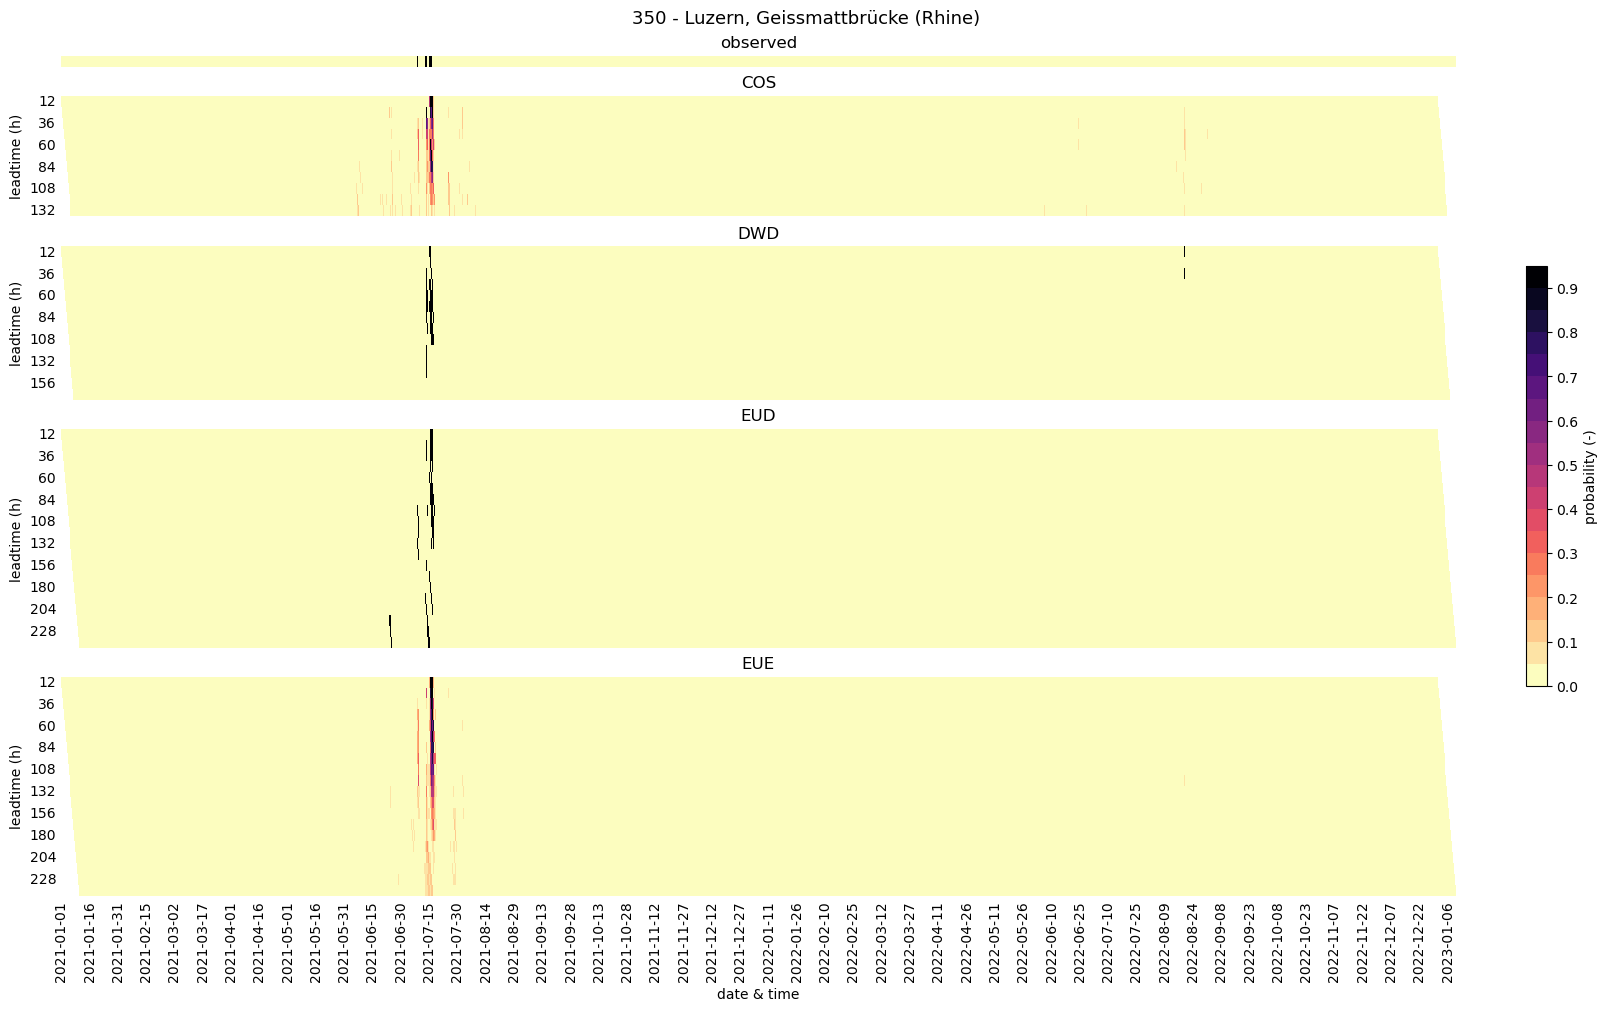

In [20]:
# plot the predicted probability for a station
stn = 350
# stn = 2996

cmap = plt.cm.magma_r
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('probability', cmaplist, cmap.N)
bounds = np.arange(0, 1, .05)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(16, 10), constrained_layout=True)
axes = []
leadtimes = [int(models[m]['leadtimes'] / 2) for m in models]
gs = fig.add_gridspec(nrows=5, height_ratios=[1] + leadtimes)

ax1 = fig.add_subplot(gs[0])
axes.append(ax1)
da = obs.sel(id=stn)
plot_DataArray(da, ax=ax1, title=f'observed', ytick_step=4, xtick_step=60, xticklabels=[], cmap=cmap, norm=norm, cbar=False)

for i, (m, lt) in enumerate(zip(models, leadtimes), start=1):
    ax = fig.add_subplot(gs[i])#, sharex=ax1)
    axes.append(ax)
    da = pred.sel(id=stn, model=m).isel(leadtime=slice(0, lt))
    if i < 4:
        xticklabels = []
        xlabel = None
    else:
        xticklabels = da.datetime.data
        xlabel = 'date & time'
    plot_DataArray(da, ax=ax, title=m, ytick_step=2, xtick_step=60, xticklabels=xticklabels,
                   xlabel=xlabel, ylabel='leadtime (h)', cmap=cmap, norm=norm, cbar=False)
        
plt.suptitle('{0} - {1} ({2})'.format(stn, *stations.loc[stn, ['name', 'catchment']]), fontsize=13)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes[:], shrink=.5, label='probability (-)');

#### 3.1.2 Skill

With the previous matrixes we can easily compute the Brier score as the mean square error of probability.

In [21]:
# squared error
se = (obs - pred)**2
# se = se.isel(leadtime=slice(0, min_leadtime)) # keep only the leadtime that is available for all models

# Brier skill of each model and station
brier = se.mean(['leadtime', 'datetime']) #.isel(leadtime=slice(0, min_leadtime))

##### All stations

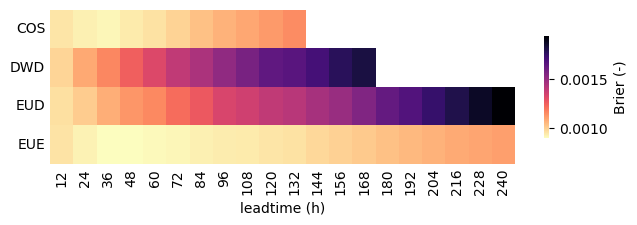

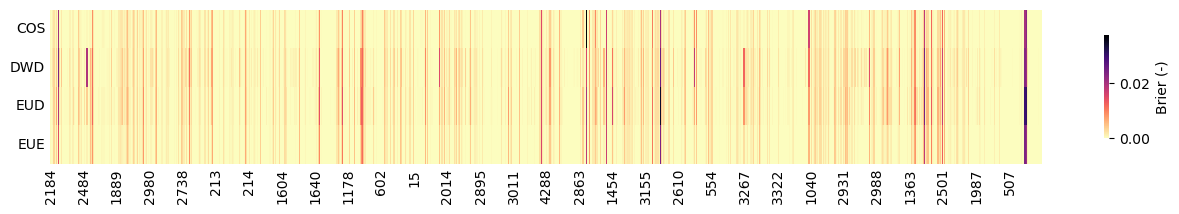

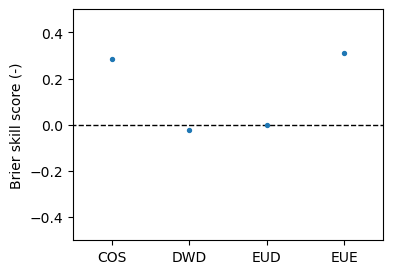

In [22]:
# plot Brier score according to model and leadtime
plot_DataArray(se.mean(['datetime', 'id']), xtick_step=1, ytick_step=1, cmap='magma_r', xlabel='leadtime (h)',
        figsize=(7.5, 2), cbar_kws={'label': 'Brier (-)', 'shrink': .666})
plt.savefig(f'{path_out}leadtime_Brier_all_stations.jpg', bbox_inches='tight', dpi=300)

# plot Brier score according to model and station
plot_DataArray(se.mean(['leadtime', 'datetime']).transpose(), yticklabels=se.model.data, ytick_step=1, xticklabels=se.id.data, xtick_step=30,
        cmap='magma_r', cbar_kws={'label': 'Brier (-)', 'shrink': .666})

# Brier skill score in terms of NWP model
BSS = 1 - brier.mean('id') / brier.sel(model='EUD').mean('id')

fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(range(0, 4), BSS.data, s=8)
ax.hlines(0, -1, 5, 'k', ls='--', lw=1, zorder=0)
ax.set_xticks(range(0, 4), BSS.model.data)
ax.set(xlim=(-.5, 3.5), ylim=(-.5, .5), ylabel='Brier skill score (-)');

name          X          Y     area  \
station_id                                                         
2149                     AVLAKION  5307500.0  1857500.0   1550.0   
2275               AGAN NAHARAYIM  6707500.0  1467500.0  53050.0   
2686           KRASNO-OKTIABRSKIY  6657500.0  2837500.0   1800.0   
1688        Lakhish-Ad Halom Park  6647500.0  1347500.0   1025.0   
4324                       Arenos  3417500.0  1952500.0   1450.0   
2996                    Burguillo  3097500.0  2042500.0   1075.0   
4114              Velino a Terria  4552500.0  2152500.0   2925.0   
4003                   Ura_Leklit  5177500.0  1962500.0   1325.0   
2596          SEREBRYANSKIY GES 1  5332500.0  5272500.0   8825.0   

                 subcatchment             river catchment country  strahler  \
station_id                                                                    
2149                 Akheloos  Acheloos Potamos  Akheloos      GR       1.0   
2275        Jordan / Dead Sea            Jordan    Jordan      JO       1.0   
2686                    Kuban         Kurdzhips     Kuban      RU       2.0   
1688                  Lakhish           Lakhish   Lakhish      IL       1.0   
4324                  Mijares           Mijares   Mijares      ES       1.0   
2996                 Alberche          Alberche     Tagus      ES       2.0   
4114                     Nera            Velino     Tiber      IT       3.0   
4003                    Vjosa            Drinos     Vjosa      AL       2.0   
2596                  Voronja           Voronja   Voronja      RU       1.0   

            pfafstetter       rl1.5          rl2          rl5         rl10  \
station_id                                                                   
2149                  1   86.995983   132.387285   244.094005   318.053573   
2275                  1  738.653631  1198.465706  2330.050307  3079.257776   
2686                  4   80.219154    89.902185   113.731854   129.509168   
1688                  1   11.349921    16.921504    30.633012    39.711223   
4324                  3    2.206204     2.928718     4.706804     5.884052   
2996                721   31.997492    45.744250    79.574636   101.973296   
4114                421  104.853308   138.887427   222.644438   278.098867   
4003                  2   70.751168    80.802296   105.537841   121.914925   
2596                  1  208.172781   229.746059   282.837290   317.988304   

                   rl20         rl50        rl100        rl200        rl500  \
station_id                                                                    
2149         388.997367   480.826831   549.640091   618.202264   708.657032   
2275        3797.915567  4728.144362  5425.219941  6119.752009  7036.055190   
2686         144.643146   164.232529   178.912015   193.537937   212.834065   
1688          48.419262    59.690924    68.137449    76.553154    87.656078   
4324           7.013297     8.474988     9.570320    10.661655    12.101465   
2996         123.458627   151.269185   172.109285   192.873343   220.267575   
4114         331.292087   400.145253   451.741012   503.148507   570.970935   
4003         137.624216   157.958282   173.195804   188.377726   208.407389   
2596         351.706001   395.350102   428.055213   460.640989   503.631733   

            n_events_5  
station_id              
2149                 5  
2275                 6  
2686                 5  
1688                 8  
4324                 7  
2996                16  
4114                 5  
4003                 6  
2596                 6

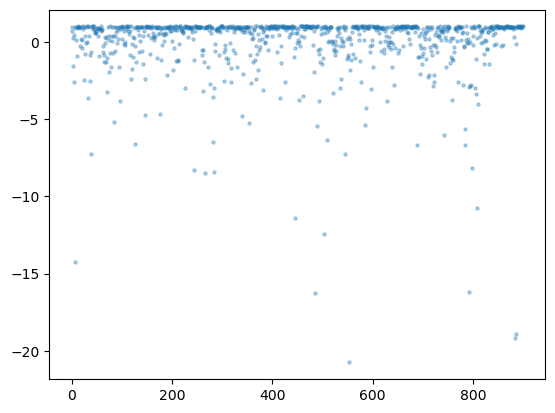

In [23]:
aux = (1 - se.mean(['datetime', 'model', 'leadtime']) / se.mean())

plt.scatter(range(aux.shape[0]), aux, s=5, alpha=.33)

bad_stations = aux.loc[aux < -10].id.data

stations.loc[bad_stations].sort_values('catchment')

The previous plot shows The Brier skill score using as a benchmark the ECMWF deterministic EUD. Positive values represent models better than the reference, whereas negative values represent models worse than the reference. As seen previously, the two probabilistic models have a higher skill than the reference, with ECMWF ensemble as the best forcing. The DWD is the worst of all the forcings. As expected, skill degrades with increasing leadtimes.

The second plot shows the Brier score by station and meteorological forcing. There are a lot of stations with Brier 0, but most of them represent stations with neither observed nor predicted events.

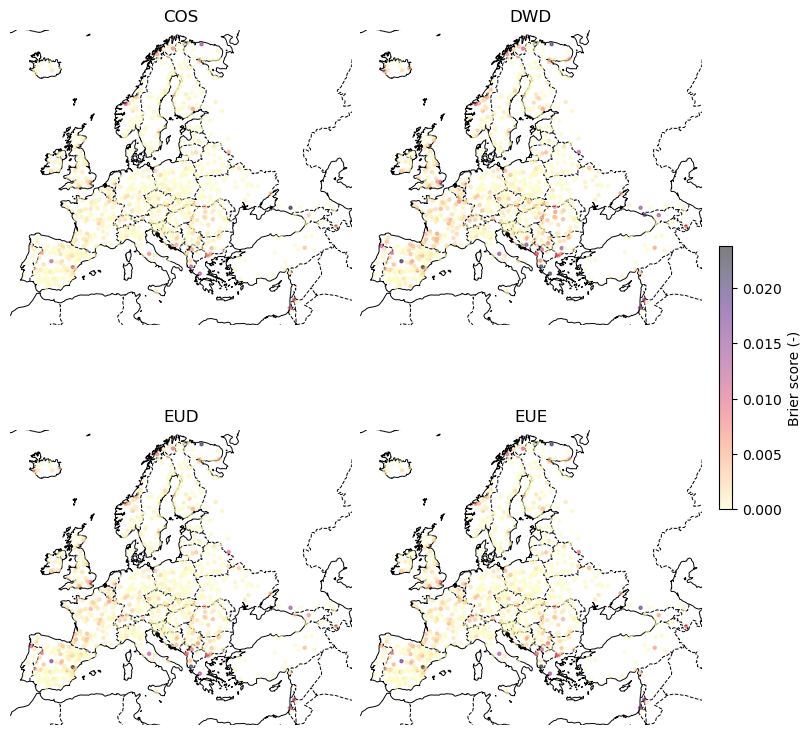

In [24]:
# plot a map of the Brier score 
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 8), subplot_kw={'projection': proj}, constrained_layout=True)
for ax, model in zip(axes.flatten(), brier.model.data):
    plot_map_stations(stations.X, stations.Y, brier.sel(model=model).to_pandas(), ax=ax,
                      rivers=None, size=5, cmap='magma_r', title=model)#, vmin=0, vmax=.022)
fig.colorbar(plot_map_stations.colorbar, ax=axes[:,1], shrink=.333, label=f'Brier score (-)');

plt.savefig(f'{path_out}eventwise_Brier_all_stations.jpg', bbox_inches='tight', dpi=300)

##### Stations with events

Here I will repeat the previous plots but removing stations without observed flood events. The objective is to check if these stations are masking the results.

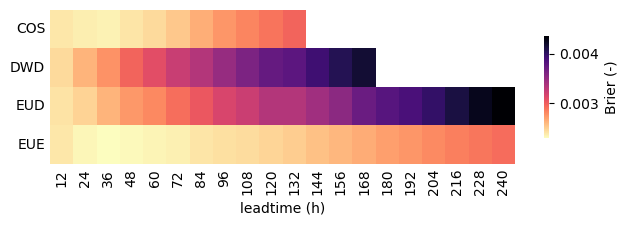

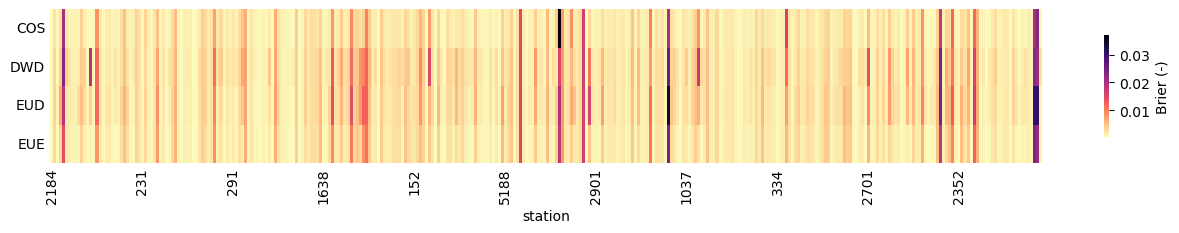

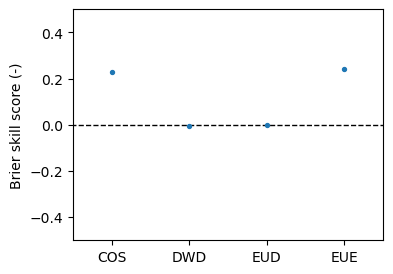

In [25]:
# select stations with events
se_ = se.sel(id=stations[mask_stn].index)

# plot Brier score according to model and forecast
plot_DataArray(se_.mean(['datetime', 'id']), xtick_step=1, ytick_step=1, cmap='magma_r', xlabel='leadtime (h)',
        figsize=(7.5, 2), cbar_kws={'label': 'Brier (-)', 'shrink': .666})
plt.savefig(f'{path_out}leadtime_Brier_stations_with_events.jpg', bbox_inches='tight', dpi=300)

# plot Brier score according to model and station
plot_DataArray(se_.mean(['leadtime', 'datetime']).transpose(), ytick_step=1, xtick_step=30, xlabel='station',
        cmap='magma_r', cbar_kws={'label': 'Brier (-)', 'shrink': .666})

# Brier skill score in terms of NWP model
BSS = 1 - brier.sel(id=stations[mask_stn].index).mean('id') / brier.sel(model='EUD', id=stations[mask_stn].index).mean('id')

fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(range(0, 4), BSS.data, s=8)
ax.hlines(0, -1, 5, 'k', ls='--', lw=1, zorder=0)
ax.set_xticks(range(0, 4), BSS.model.data)
ax.set(xlim=(-.5, 3.5), ylim=(-.5, .5), ylabel='Brier skill score (-)');

The results are very similar to those that take into account all the stations, not only those with observed flood events. The Brier values, though, are a bit lower.

These two previous plots show that the probabilistic forcings (COS and EUE) have a better Brier score than the deterministic forcings (DWD and EUE). Between the two deterministic forcings, EUD seems to have a larger leadtime skill (up to the 5th forecast).

Empty DataFrame
Columns: [name, X, Y, area, subcatchment, river, catchment, country, strahler, pfafstetter, rl1.5, rl2, rl5, rl10, rl20, rl50, rl100, rl200, rl500, n_events_5]
Index: []

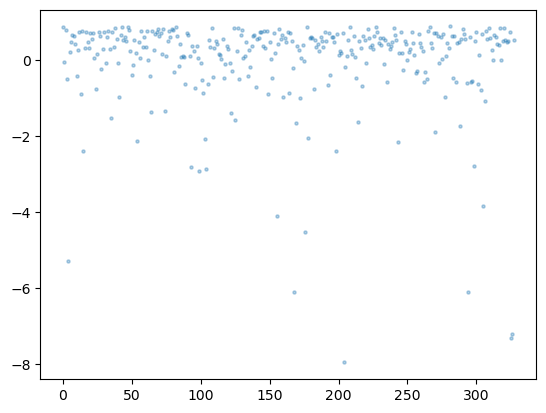

In [26]:
aux = (1 - se_.mean(['datetime', 'model', 'leadtime']) / se_.mean())

plt.scatter(range(aux.shape[0]), aux, s=5, alpha=.33)

bad_stations = aux.loc[aux < -10].id.data

stations.loc[bad_stations].sort_values('catchment')

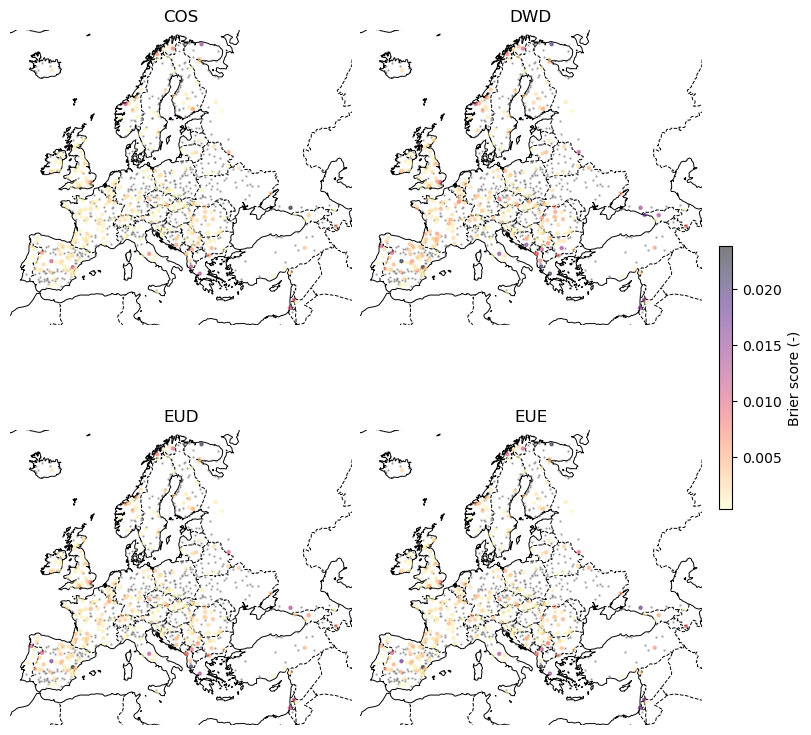

In [27]:
# plot a map of the Brier score 
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 8), subplot_kw={'projection': proj}, constrained_layout=True)
for ax, model in zip(axes.flatten(), brier.model.data):
    plot_map_stations(stations.X, stations.Y, brier.sel(model=model).to_pandas(), mask=~mask_stn, ax=ax,
                      rivers=None, size=5, cmap='magma_r', title=model)#, vmin=0, vmax=.022)
fig.colorbar(plot_map_stations.colorbar, ax=axes[:,1], shrink=.333, label=f'Brier score (-)');

plt.savefig(f'{path_out}eventwise_Brier_stations_with_events.jpg', bbox_inches='tight', dpi=300)

### 3.2 Where events predicted at any point in time?

The objective of this section is to check if actual events where predicted at all, no matter leadtime.

To convert exceedance probability for each meteo forcing against events we need to come up with a total exceedance probability, i.e., combine the probabilities of each model into a single probability value. This total probability will later be compared against a probability threshold to discern events. I will test four different approaches:

* `current`:  the current notification criteria. At least a probabilistic and deterministic model must exceed the probability threshold.
* `model_mean`
* `member_weighted`
* `brier_weighted`

#### 3.2.1 Exceedance over probability threshold

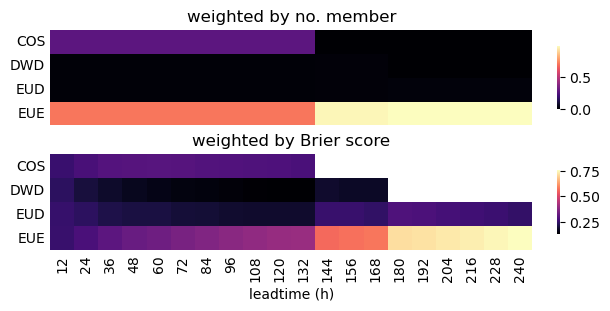

In [28]:
# exceedance according to current criteria
deterministic = (pred.sel(model=['EUD', 'DWD']) > probabilities).any('model')
probabilistic = (pred.sel(model=['EUE', 'COS']) > probabilities).any('model')
current = deterministic & probabilistic

# exceedance according to mean over models
model_mean = pred.mean('model', skipna=True) > probabilities

# exceedance according to the mean over models weighted by the number of members
weights_member = weights.isel(leadtime=slice(None, None, 2))
weights_member['leadtime'] = pred.leadtime
weights_member /= weights_member.sum('model')
member_weighted = pred.weighted(weights_member).mean('model', skipna=True) > probabilities

# exceedance according to the mean over models weighted by the inverse Brier score
brier = se.mean(['id', 'datetime'])
weights_brier = 1 / brier**2
weights_brier /= weights_brier.sum('model')
brier_weighted = pred.weighted(weights_brier.fillna(0)).mean('model', skipna=True) > probabilities
# exportar weights based on the Brier score
weights_brier.to_netcdf(f'{path_out}weights_brier.nc')

# merge all in a single DataArray
pred_reshape = xr.Dataset({'current': current,
                           'model_mean': model_mean,
                           'member_weighted': member_weighted,
                           'brier_weighted': brier_weighted}).to_array(dim='combination')

# heatmap of weights
fig, axes = plt.subplots(nrows=2, figsize=(6, 3), constrained_layout=True, sharex=True, sharey=True)
Weights = xr.Dataset({'no. member': weights_member, 'Brier score': weights_brier})
for i, (ax, (var, da)) in enumerate(zip(axes, Weights.items())):
    htm = plot_DataArray(da, vmin=0, vmax=1, ax=ax, ytick_step=1, xtick_step=1, title=f'weighted by {var}', cbar_kws={'shrink': .66})
    if i == len(axes) - 1:
        ax.set_xlabel('leadtime (h)')

In [34]:
del pred

To create a weight based on the Brier score I need to invert the values, since lower Brier score values represent better models. Therefore, I compute the inverse of the squared Brier score. To normalize weights (values between 0 and 1) I divide the previous weight matrix by its sum over models.

The previous plot shows the weighting factors for the mean weighted by the number of members of each model (top), and the mean weighted by the performace of the model measured in terms of Brier score (bottom). When taking into account the number of members, obviously COSMO-LEPS and EUE get the vast majority of the weight, rendering no importance to any of the deterministic models. Between the two probabilistic models, EUE prevails over COSMO-LEPS, even though we've seen that their performance is comparable. However, when weighting according to performance, COSMO-LEPS and EUE get a very similar value during the leadtime span for which COSMO-LEPS is available. The probabilistic models have lower weights, but not as insignificat as when weighting by the number of members. In this sense, this last weighting method is a mid ground point between the simple model mean and the mean weighted by the number of members.

#### Graphical explanation of the procedure

**Centered rolling sum**

Initially, I applied **centered** moving sums to apply a buffer in the prediction of the flood event. 

However, Christel proposed to apply an asymmetric window, so we allow for slight lags between prediction and observation, but only when the onset of the predicted event is earlier than the observation (not when the prediction was late). To apply this idea, the moving sums must be **rght-sided**.

In [83]:
def compute_events(da, persistence=(1, 1), min_leadtime=None):
    """
    """
    
    # compute persistence (rolling sum over a window exceeds a number of forecast positives)
    events = da.astype(int).rolling({'leadtime': persistence[0]}).sum() >= persistence[1]
    
    # check if there's any predicted event
    if min_leadtime is None:
        return events.any('leadtime').astype(int)
    else:
        return events.sel(leadtime=slice(min_leadtime, None)).any('leadtime').astype(int)

In [87]:
def buffer_events(da, center=True, w=5):
    """
    """
    
    if center:
        mp = int(w / 2) + 1
        buffer = (da.rolling({'datetime': w}, center=True, min_periods=mp).sum() > 0).astype(int)
    else:
        mp = 1 # int(w / 2)
        buffer = (da.rolling({'datetime': w}, center=False, min_periods=mp).sum() > 0).astype(int)
        
    return buffer

Station 350 has 3 observed events
Station 350 has 2 predicted events
TP:	2
FN:	1
FP:	0
recall:		0.667
precision:	1.000
f1:		0.800


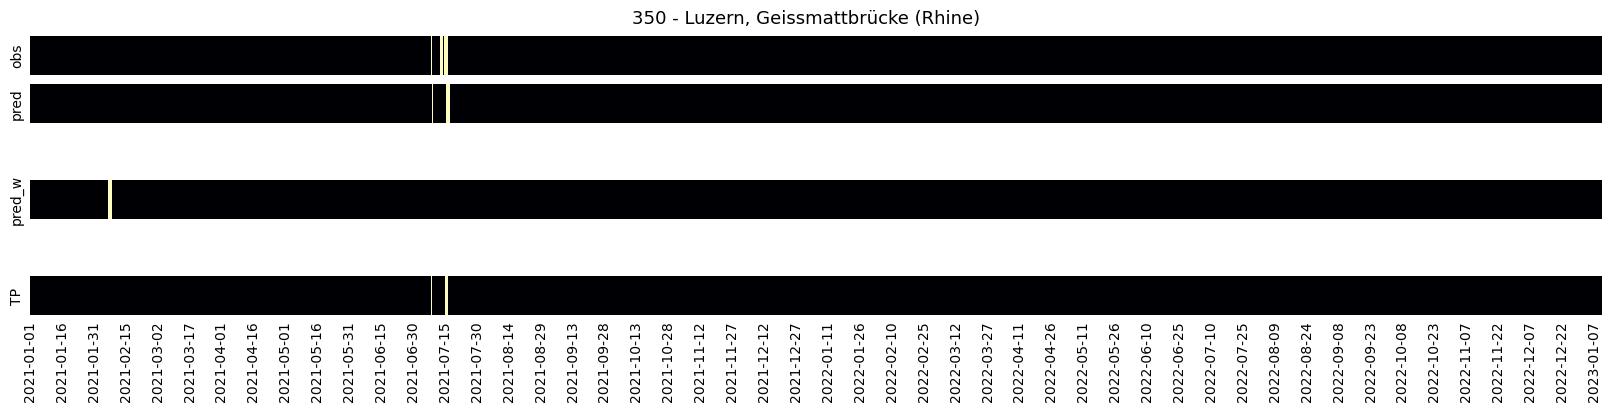

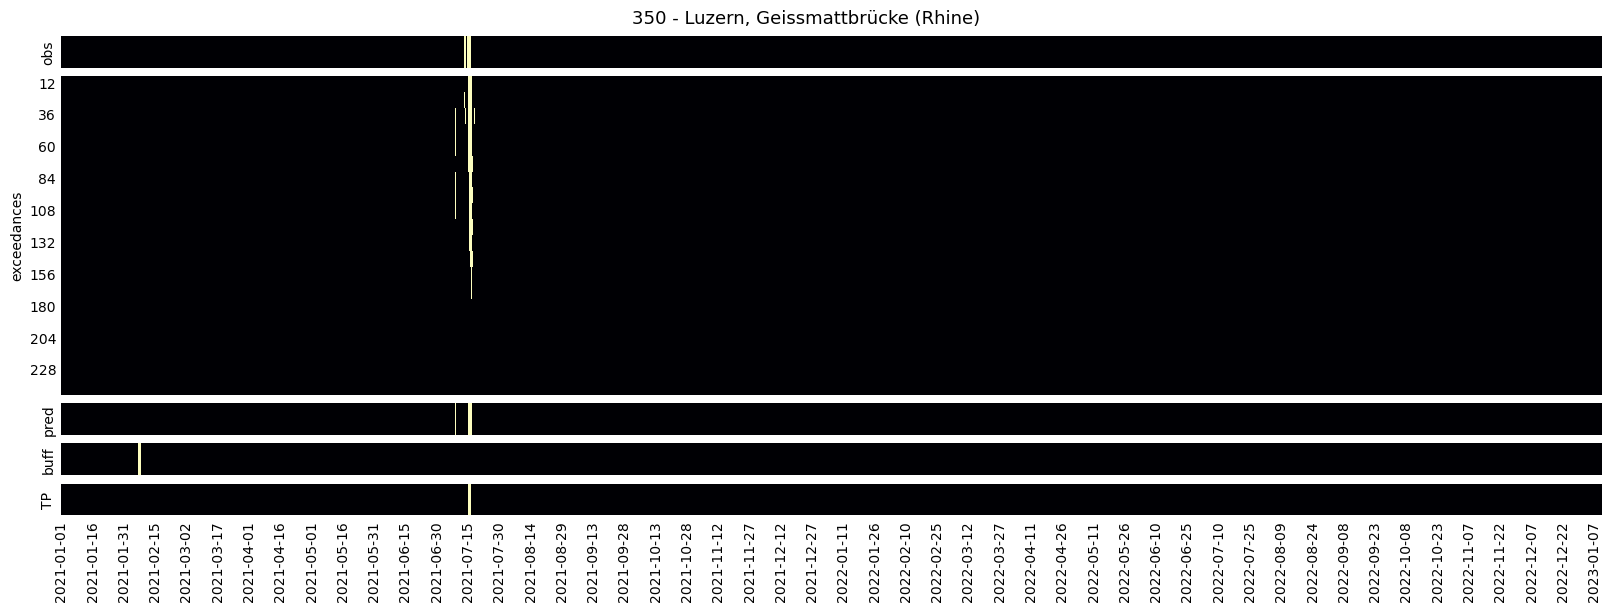

In [96]:
stn = 350 #119 #n_events_obs.idxmax().data # 119 # 350 
probability = .3
comb = 'member_weighted'
persistence_span = 3
persistence_positives = 3

das = {'obs': obs.sel(id=stn), 
       'pred': compute_events(pred_reshape.sel(id=stn, probability=probability, combination=comb), persistence=(3, 3), min_leadtime=60)}

n_events_pred = (xr.concat([das['pred'].isel(datetime=[0]), das['pred'].diff('datetime')], dim='datetime') == 1).sum('datetime').data

print('Station {0} has {1} observed events'.format(stn, n_events_obs.sel(id=stn).data))
print('Station {0} has {1} predicted events'.format(stn, n_events_pred))

# centered rolling sum of observations and predictions
center, w = True, 5 # False, 3
das['pred_w'] = buffer_events(das['pred'], center=True, w=w)

# compute true positives
aux1 = das['pred_w'].where(das['obs'] == 1)
das['TP'] = (aux1 == 1).astype(int)

# compute performance metrics
TP = (das['TP'].isel(datetime=0) + (das['TP'].diff('datetime') == 1)).sum('datetime')
TP = xr.ufuncs.minimum(TP, n_events_obs.sel(id=stn)).data
FN = n_events_obs.sel(id=stn).data - TP
FP = max(0, n_events_pred - TP)
print(f'TP:\t{TP}\nFN:\t{FN}\nFP:\t{FP}')
print('recall:\t\t{0:.3f}\nprecision:\t{1:.3f}\nf1:\t\t{2:.3f}'.format(TP / (TP + FN),
                                                                        TP / (TP + FP),
                                                                        2 * TP / (2 * TP + FP + FN)))

fig, ax = plt.subplots(nrows=6, figsize=(16, 4), sharex=True, sharey=True, constrained_layout=True)
plot_DataArray(das['obs'], ax=ax[0], xtick_step=60, cbar=False, ylabel='obs')
plot_DataArray(das['pred'], ax=ax[1], xtick_step=60, cbar=False, ylabel='pred')
ax[2].axis('off')
plot_DataArray(das_w['pred'], ax=ax[3], xtick_step=60, cbar=False, ylabel='pred_w')
ax[4].axis('off')
plot_DataArray(das['TP'], ax=ax[5], xtick_step=60, cbar=False, ylabel='TP')
fig.suptitle('{0} - {1} ({2})'.format(stn, *stations.loc[stn, ['name', 'catchment']]), fontsize=13);


fig = plt.figure(figsize=(16, 6), constrained_layout=True)
height_ratios = [1, len(exc.leadtime) / 2, 1, 1, 1]
gs = fig.add_gridspec(nrows=len(height_ratios), height_ratios=height_ratios)
plot_DataArray(das['obs'], xtick_step=60, cbar=False, ylabel='obs', xticklabels=[], ax=fig.add_subplot(gs[0]))
plot_DataArray(pred_reshape.sel(id=stn, probability=probability, combination=comb), xtick_step=60, ytick_step=2, cbar=False, ylabel='exceedances', xticklabels=[], ax=fig.add_subplot(gs[1]))
plot_DataArray(das['pred'], xtick_step=60, cbar=False, ylabel='pred', xticklabels=[], ax=fig.add_subplot(gs[2]))
plot_DataArray(das_w['pred'], xtick_step=60, cbar=False, ylabel='buff', xticklabels=[], ax=fig.add_subplot(gs[3]))
plot_DataArray(das['TP'], xtick_step=60, cbar=False, ylabel='TP', ax=fig.add_subplot(gs[4]))
fig.suptitle('{0} - {1} ({2})'.format(stn, *stations.loc[stn, ['name', 'catchment']]), fontsize=13);

<img src='../results/reporting_points/Rhine/no_events_119.png' alt="Observed discharge" />

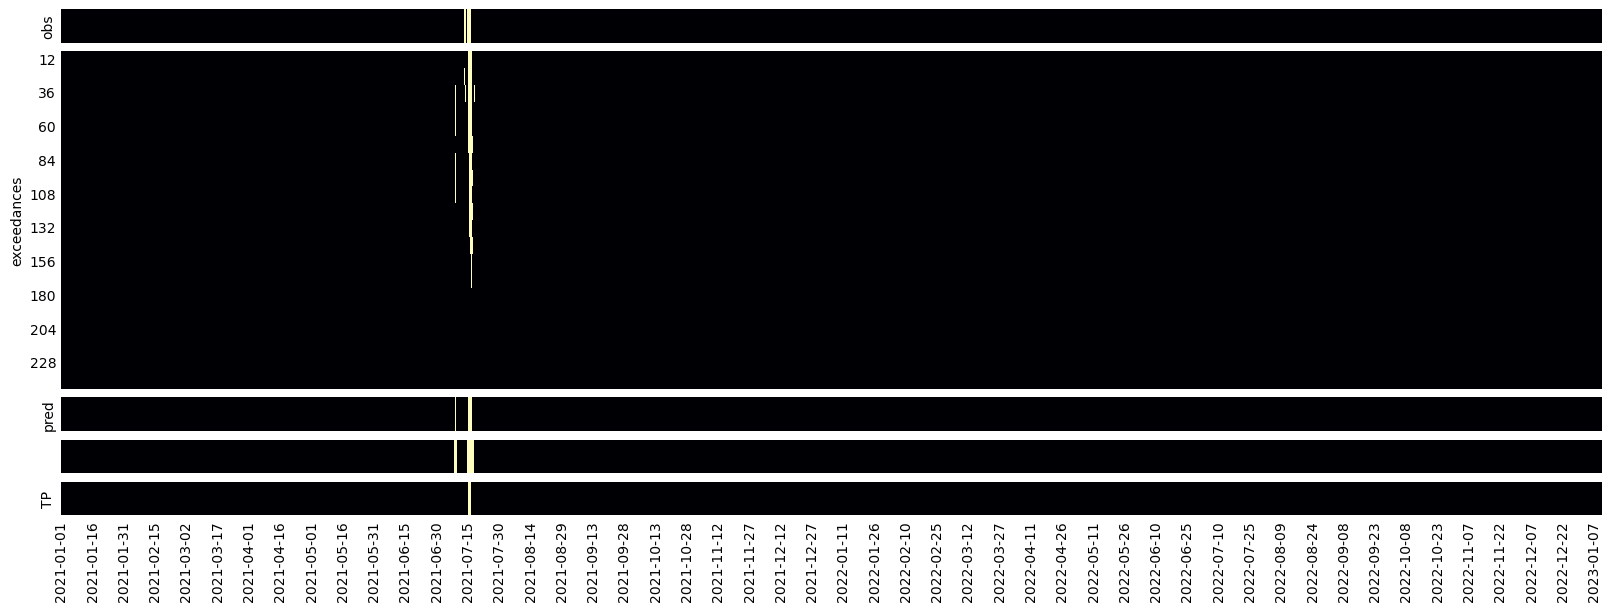

In [80]:
fig = plt.figure(figsize=(16, 6), constrained_layout=True)
height_ratios = [1, len(exc.leadtime) / 2, 1, 1, 1]
gs = fig.add_gridspec(nrows=len(height_ratios), height_ratios=height_ratios)

plot_DataArray(das['obs'], xtick_step=60, cbar=False, ylabel='obs', xticklabels=[], ax=fig.add_subplot(gs[0]))
plot_DataArray(exc, xtick_step=60, ytick_step=2, cbar=False, ylabel='exceedances', xticklabels=[], ax=fig.add_subplot(gs[1]))
plot_DataArray(das['pred'], xtick_step=60, cbar=False, ylabel='pred', xticklabels=[], ax=fig.add_subplot(gs[2]))
plot_DataArray(das_w['pred'], xtick_step=60, cbar=False, ylabel='', xticklabels=[], ax=fig.add_subplot(gs[3]))
plot_DataArray(das['TP'], xtick_step=60, cbar=False, ylabel='TP', ax=fig.add_subplot(gs[4]))

**Compute for all the stations**

***
I will add the persistence to the criteria required to consider an event.

no. observed events:	3
no. predicted events:	2


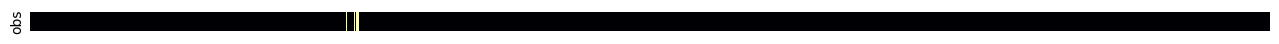

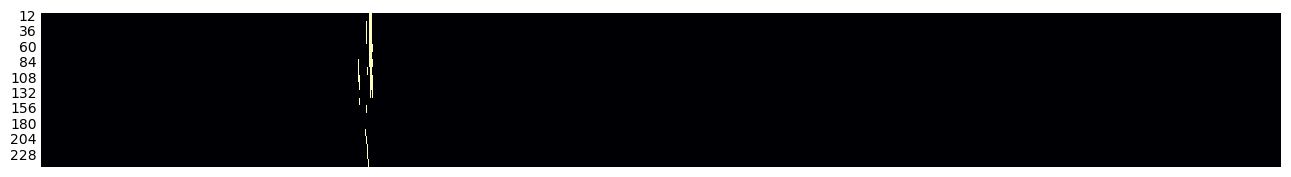

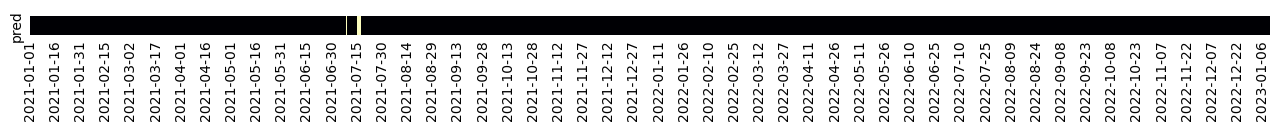

In [50]:
stn = 350
print('no. observed events:\t{0}'.format(n_events_obs.sel(id=stn).data))

persistence_span = 3
persistence_positives = 3

# exceedance over probabilities
da = pred_reshape.sel(combination='brier_weighted', id=stn, probability=.3).astype(int)
# compute persistence (rolling sum over a window exceeds a number of forecast positives)
events = (da.rolling({'leadtime': persistence_span}).sum() >= persistence_positives)
# limit the dataset from 48 h leadtime onwards
events = events.sel(leadtime=slice(60, None))
# check if for every datetime there is any prediction that complies with the persistence criteria
events = events.any('leadtime')
print('no. predicted events:\t{0}'.format((events.astype(int).diff('datetime') == 1).sum().data))

# plot observed events
plot_DataArray(obs.sel(id=stn), xtick_step=60, ylabel='obs', figsize=(16, .25), xticklabels=[], cbar=False)
# plot the exceedances
plot_DataArray(da, xtick_step=60, ytick_step=2, xticklabels=[], cbar=False)
# plot the notifications
plot_DataArray(events, xtick_step=60, ylabel='pred', figsize=(16, .25), cbar=False)

In [ ]:
print('no. observed events:\t{0}'.format(n_events_obs.sel(id=stn).data))

persistence_span = 4
persistence_positives = 2

# exceedance over probabilities
da = pred_reshape.sel(combination='brier_weighted', id=stn, probability=.3).astype(int)
# compute persistence (rolling sum over a window exceeds a number of forecast positives)
events = (da.rolling({'leadtime': persistence_span}).sum() >= persistence_positives)
# limit the dataset from 48 h leadtime onwards
events = events.sel(leadtime=slice(60, None))
# check if for every datetime there is any prediction that complies with the persistence criteria
events = events.any('leadtime')
print('no. predicted events:\t{0}'.format((events.astype(int).diff('datetime') == 1).sum().data))

# plot observed events
plot_DataArray(obs.sel(id=stn), xtick_step=60, ylabel='obs', figsize=(16, .25), xticklabels=[], cbar=False)
# plot the exceedances
plot_DataArray(exc.sel(id=stn, probability=.3), xtick_step=60, ytick_step=2, xticklabels=[], cbar=False)
# plot the notifications
plot_DataArray(events, xtick_step=60, ylabel='pred', figsize=(16, .25), cbar=False)

In [ ]:
# compute persistence (rolling sum over a window exceeds a number of forecast positives)
notifications = pred_reshape.astype(int).rolling({'leadtime': persistence_span}).sum() >= persistence_positives
# limit the dataset from 48 h leadtime onwards
notifications = notifications.sel(leadtime=slice(60, None))
# check if for every datetime there is any prediction that complies with the persistence criteria
notifications = notifications.any('leadtime')

In [ ]:
notifications

***

In [ ]:
# DataArrays of exceedance over threshold
das = {'obs': obs, 
       'pred': pred_reshape.any('leadtime').astype(int)} #.sel(probability=.3)

n_events_pred = (xr.concat([das['pred'].isel(datetime=[0]), das['pred'].diff('datetime')], dim='datetime') == 1).sum('datetime').data

# centered rolling sum of observations and predictions
# w = 5
# mp = int(w / 2) + 1
# das['pred_w'] = das['pred'].rolling({'datetime': w}, center=True, min_periods=mp).sum() > 0

# right-sided rolling sum of observations and predictions
w = 3
mp = 1
das['pred_w'] = das['pred'].rolling({'datetime': w}, center=False, min_periods=mp).sum() > 0

# compute true positives
tp = (das['pred_w'].where(das['obs']) == 1).astype(int)

In [ ]:
tp = (tp.isel(datetime=0) + (tp.diff('datetime') == 1)).sum('datetime')
tp = xr.ufuncs.minimum(tp, n_events_obs)
# compute false negatives and false positives
fn = n_events_obs - tp
fp = xr.ufuncs.maximum(0, n_events_pred - tp)

# compute metrics
skill = xr.Dataset({'recall': tp.sum('id') / (tp.sum('id') + fn.sum('id')),
                   'precision': tp.sum('id') / (tp.sum('id') + fp.sum('id')),
                   'f1': 2 * tp.sum('id') / (2 * tp.sum('id') + fp.sum('id') + fn.sum('id'))})#.to_array(dim='metric')

In [ ]:
# plot true positives, false negatives and false positives
plot_DataArray(tp.sum('id'), cbar_kws={'label': 'true positives'})
plot_DataArray(fn.sum('id'), cmap='magma_r', cbar_kws={'label': 'false negatives'})
plot_DataArray(fp.sum('id'), cmap='magma_r', cbar_kws={'label': 'false positives'})

False positives are one order of magnitued larger than both true positives and true negatives. This will be important it the succeding analysis, since precision will be very close to 0 for low probability thresholds, i.e., those thresholds with highest true positives and false negatives.

In [ ]:
r = .05
vmax = np.ceil(skill.max().to_array().max() / r) * r
vmin = np.floor(skill.min().to_array().min() / r) * r

cmap = plt.cm.Blues
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('performance', cmaplist, cmap.N)
bounds = np.arange(vmin, vmax, r)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plot_skill_eventwise(skill, cmap=cmap, norm=norm, save=f'{path_out}eventwise_average_skill_(all_stations).jpg')

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(13, 4), sharex=True, sharey=True)

for ax, (metric, da) in zip(axes, skill.items()):
    for i,comb in enumerate(da.combination.data):
        ax.plot(da.probability, da.sel(combination=comb), lw=1, c=f'C{i}', label=comb)
    ax.set_title(metric)
    ax.set_xlabel('probability (-)')
ax.set(ylim=(-.05, 1.05))
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=8, ncol=4, bbox_to_anchor=[.1, -.1, .8, .1]);

<font color='red'>Precision-recall curves!</font>

In [ ]:
rean_exc.sum().sum() / rean_exc.size

In [ ]:
rean_onsets.sum().sum() / rean_onsets.size

In [ ]:
fig, ax = plt.subplots(figsize=(4.3, 4))
for comb in skill.combination.data:
    ax.plot(skill['recall'].sel(combination=comb), skill['precision'].sel(combination=comb), lw=1, label=comb)
ax.hlines(rean_onsets.sum().sum() / rean_onsets.size, 0, 1, ls='--', lw=1, color='k')
ax.set(xlim=(0, 1), ylim=(0, 1), xlabel='recall', ylabel='precision', aspect='equal')
ax.legend(fontsize=9);

The precision-recall curves above are not really insightful:

1. The curves don't cover the complete range (0-1) neither for precision nor for recall.The range among which recall varies is higher and shorter (0.4-0.7) than in the case of precision (0.1-0.5)

**All the stations**

In [ ]:
# # plot performace for individual stations
# filename = f'{path_out}eventwise_station_skill_(all_stations).jpg'
# plot_skill(skill, xtick_step=50, save=filename, figsize=(24, 14))

* Most of the stations are in white, which means that they didn't have neither observed nor forecasted events. This specifically noticeable in the recall.
* Lower probability threshols optimize recall.
* Higher probability thresholds optimize precision.
* Even f1 is the harmonic mean of recall and precision, its peak values are also for high probability thresholds. The highest value of all is obtained by the `brier_weighted` method and the 90% probability.

> <font color='red'>Improve this figure to show the best performing option for each model and metric.</font>

The previous plot summarizes performance over stations. The general look of all models is similar, but there are slight differences:

* `model_mean` and `brier_weighted` are very similar, with slightly higher values for `brier_weighted`. Their main difference compared with the other two models is a marked higher precision at larger probability thresholds.
* `current` and `member_weighted` look very alike, with slightly higher performance for the latter.

In [ ]:
# find probability threshold that optimizes f1 for a given model
metric = 'f1'
com = 'brier_weighted'
best_p = skill[metric].sel(combination=comb).mean('id').idxmax(dim='probability', skipna=True)

# plot a map of the metrics
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=10, central_latitude=52, false_easting=4321000, false_northing=3210000, globe=ccrs.Globe(ellipse='GRS80'))
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), subplot_kw={'projection': proj}, constrained_layout=True)
for ax, metric in zip(axes, list(skill)):
    # extract metric values for stations
    metric_id = skill[metric].sel(combination=comb, probability=best_p).to_pandas()
    # plot a map metric
    plot_map_stations(stations.X, stations.Y, metric_id, ax=ax,
                      rivers=None, size=8, cmap='coolwarm_r', title=metric)
fig.text(.475, 1.025, f'{comb} | p = {best_p.data:.2f}', horizontalalignment='center', fontsize=13)
fig.colorbar(plot_map_stations.colorbar, shrink=.5, label=f'(-)');

# plt.savefig(f'{path_out}eventwise_skill_map_(all_stations).jpg', bbox_inches='tight', dpi=300)

Surprisingly, there's a larger amount of stations with poor recall (red dots in the left panel) than precision (red dots in the central panel). This means that there is a stronger tendency towards missing events than towards mistakenly producing events.

A priori, there's no clear pattern in the geographical location of high or poor performing stations.

**Stations with events**

Let's repeat the previous plots but taking into account only stations with observed flood events.

In [ ]:
# plot performace for individual stations
stns = stations[mask_stn].index
filename = f'{path_out}eventwise_station_skill_(stations_with_events).jpg'
plot_skill(skill.sel(id=stns), xtick_step=50, save=filename, figsize=(24, 14))

Compared with the similar plot with all stations, there is barely no white in this one, where white means stations with neither observed nor predicted events.

* Recall values seem higher in general (larger areas dark blue). Lower probability thresholds optimize recall.
* As seen before, recall improves with larger probability thresholds. Specifically for the methods `model_mean` and `brier_weighted`, there is clear threshold above which some stations show high precision.
* The highest f1 score is obtained by the `current` model at 30% probability, which is the actual curren probability threshold.

In [ ]:
# plot average performance over stations
stn = stations[mask_stn].index
fig, axes = plt.subplots(nrows=len(skill.combination), figsize=(7.5, 6), constrained_layout=True, sharex=True, sharey=True)
for i, (ax, comb) in enumerate(zip(axes, skill.combination.data)):
    da = skill.sel(combination=comb, id=stn).mean('id').to_array(dim='metric')
    if i == 1:
        cbar = True
    else:
        cbar = False
    plot_DataArray(da, xtick_step=1, ytick_step=1, cmap='Blues', ax=ax, vmin=0, vmax=1, cbar=cbar, title=comb,
            cbar_kws={'shrink': 1.5, 'label': 'metric (-)'})
    if i == len(skill.combination) - 1:
        ax.set_xlabel('probability (-)')
        
    print(comb.upper().replace('_', ' '))
    print('-' * len(comb))
    print('Best probability thresholds\n{0}:\t\t{3:.3f}\n{1}:\t{4:.3f}\n{2}:\t\t{5:.3f}\n'.format(*da.metric.data, *da.idxmax('probability').data))
    
plt.savefig(f'{path_out}eventwise_average_skill_(stations_with_events).jpg', bbox_inches='tight', dpi=300)

The conclusions are very similar to those commented on the similar plot with all stations. However, performace is higher in general.

In [ ]:
# find probability threshold that optimizes f1 for a given method
metric = 'f1'
comb = 'current'
stn = stations[mask_stn].index
best_p = skill[metric].sel(combination=comb, id=stn).mean('id').idxmax(dim='probability', skipna=True)

# plot a map of the metrics
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=10, central_latitude=52, false_easting=4321000, false_northing=3210000, globe=ccrs.Globe(ellipse='GRS80'))
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), subplot_kw={'projection': proj}, constrained_layout=True)
for ax, metric in zip(axes, list(skill)):
    # extract metric values for stations
    metric_id = skill[metric].sel(combination=comb, probability=best_p).to_pandas()
    # plot a map of themetric
    plot_map_stations(stations.X, stations.Y, metric_id, mask=~mask_stn, ax=ax,
                      rivers=None, size=8, cmap='coolwarm_r', title=metric)
fig.text(.475, 1.025, f'{comb} | p = {best_p.data:.2f}', horizontalalignment='center', fontsize=13)
fig.colorbar(plot_map_stations.colorbar, shrink=.5, label=f'(-)');

plt.savefig(f'{path_out}eventwise_skill_map_(stations_with_events).jpg', bbox_inches='tight', dpi=300)

As explained before, there are more stations with poor recall than precision.

In [ ]:
metric = 'f1'
attr = 'area'

comb = 'brier_weighted'
p = .9

fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharex=True, sharey=True, constrained_layout=True)

for i, (ax, metric) in enumerate(zip(axes, list(skill))):
    ax.scatter(stations[attr], skill.sel(combination=comb, probability=p)[metric].to_pandas(), s=5, alpha=.33)
    ax.set_title(metric)
    ax.set_xlabel(attr)
    if i == 0:
        ax.set_ylabel('metric (-)')

In [ ]:
def plot_skill_vs_attribute(skill, combination, probability, attribute, id=None, **kwargs):
    """
    """
    
    fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharex=True, sharey=True, constrained_layout=True)
    
    if id is None:
        ds = skill.sel(combination=comb, probability=probability)
        x = attribute
    else:
        ds = skill.sel(id=id, combination=comb, probability=probability)
        x = attribute.loc[id]
    for i, (ax, metric) in enumerate(zip(axes, list(ds))):
        ax.scatter(x, ds[metric].to_pandas(), s=5, alpha=.33)
        ax.set_title(metric)
        if 'xlabel' in kwargs:
            ax.set_xlabel(kwargs['xlabel'])
        if i == 0:
            ax.set_ylabel('metric (-)')

In [ ]:
attr = 'area'
plot_skill_vs_attribute(skill, 'brier_weighted', .3, stations[attr], xlabel=attr)

In [ ]:
attr = 'area'
plot_skill_vs_attribute(skill, 'brier_weighted', .3, stations[attr], id=stn, xlabel=attr)